### **Universidade Federal do Rio Grande do Norte - UFRN**

### **Programa de Pós Graduação em Engenharia Elétrica e de Computação - PPgEEC**

### PPGEEC 2327 - Tópicos Especiais em Processamento Inteligente da Informação

#### Docente: Tiago Tavares Leite Barros

#### Discente: Matheus Gomes Diniz Andrade


# Importing

In [25]:
import warnings
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler

import torch.nn.functional as F

from utils.metrics import evaluate

from typing import List, Tuple, Optional

from torchinfo import summary


In [26]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Aquisição dos Dados

In [27]:
data = pd.read_csv('../data/co2.csv')

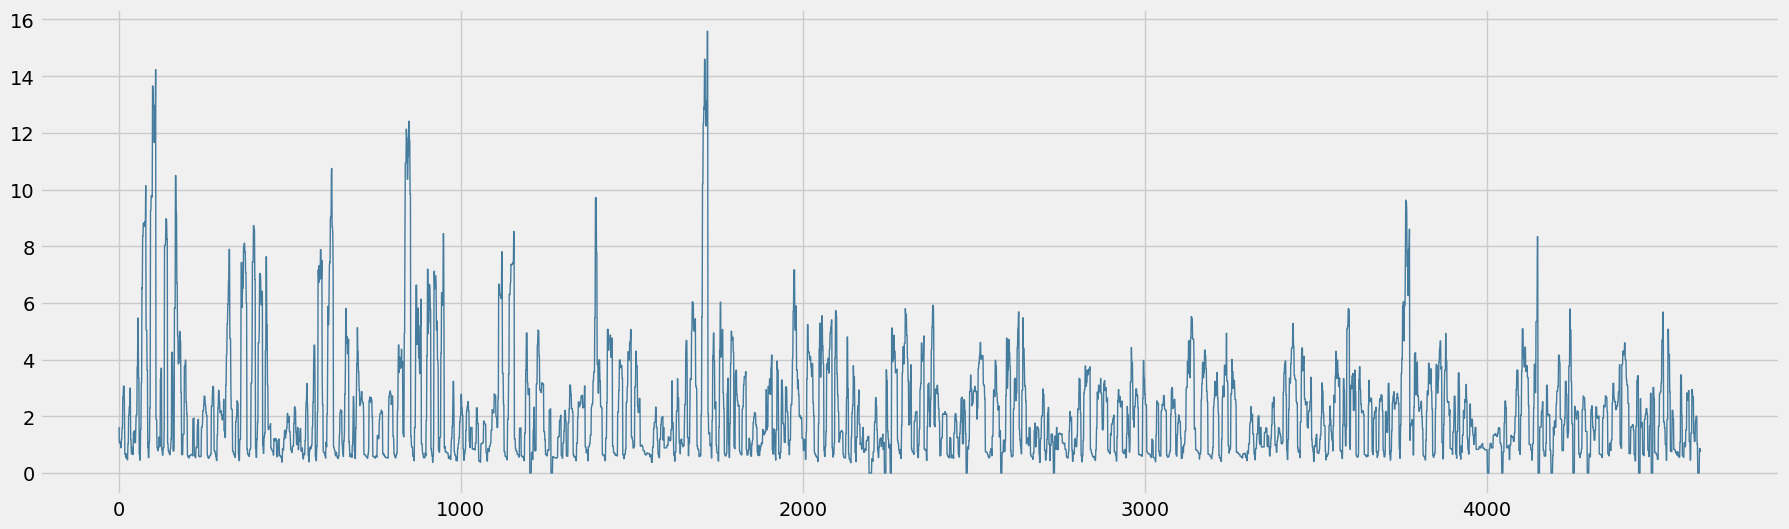

In [28]:
plt.figure(figsize=(20, 6))

plt.plot(data, linewidth=1, color="#457B9D")

plt.show()

# Preparação dos Dados

In [29]:
resultado = adfuller(data["co2"])

if resultado[1] > 0.05:
    print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
    print('Essa série provavelmente não é estacionária.')
else:
    print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
    print('Essa série provavelmente é estacionária.')


O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [30]:
resultado = kpss(data["co2"])

if resultado[1] > 0.05:
    print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula (H0).')
    print('A série temporal provavelmente é estacionária.')
else:
    print('\nO valor-p é menor ou igual a 0.05 e, portanto, rejeitamos a hipótese nula (H0).')
    print('A série temporal provavelmente não é estacionária.')


O valor-p é menor ou igual a 0.05 e, portanto, rejeitamos a hipótese nula (H0).
A série temporal provavelmente não é estacionária.


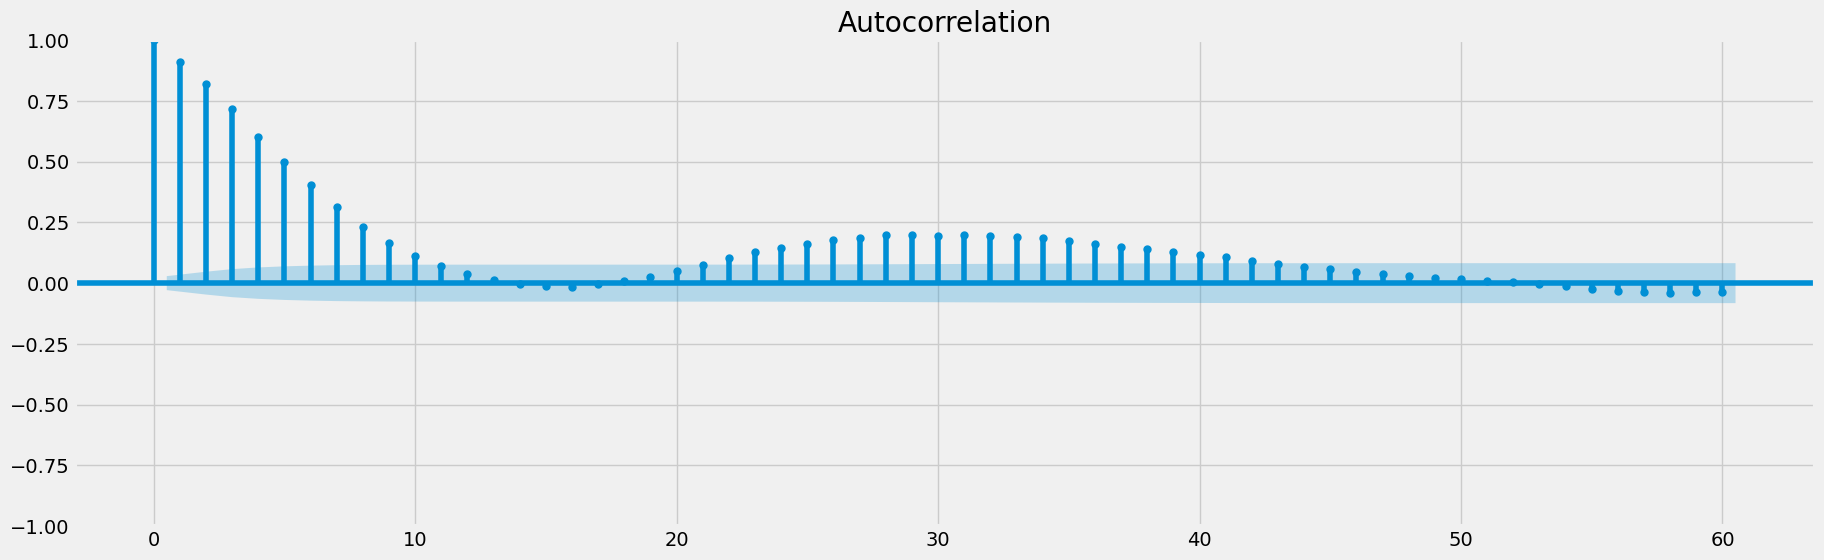

In [31]:
fig, ax = plt.subplots(figsize=(20, 6))

plot_acf(data["co2"], lags=60, ax=ax)

plt.show()

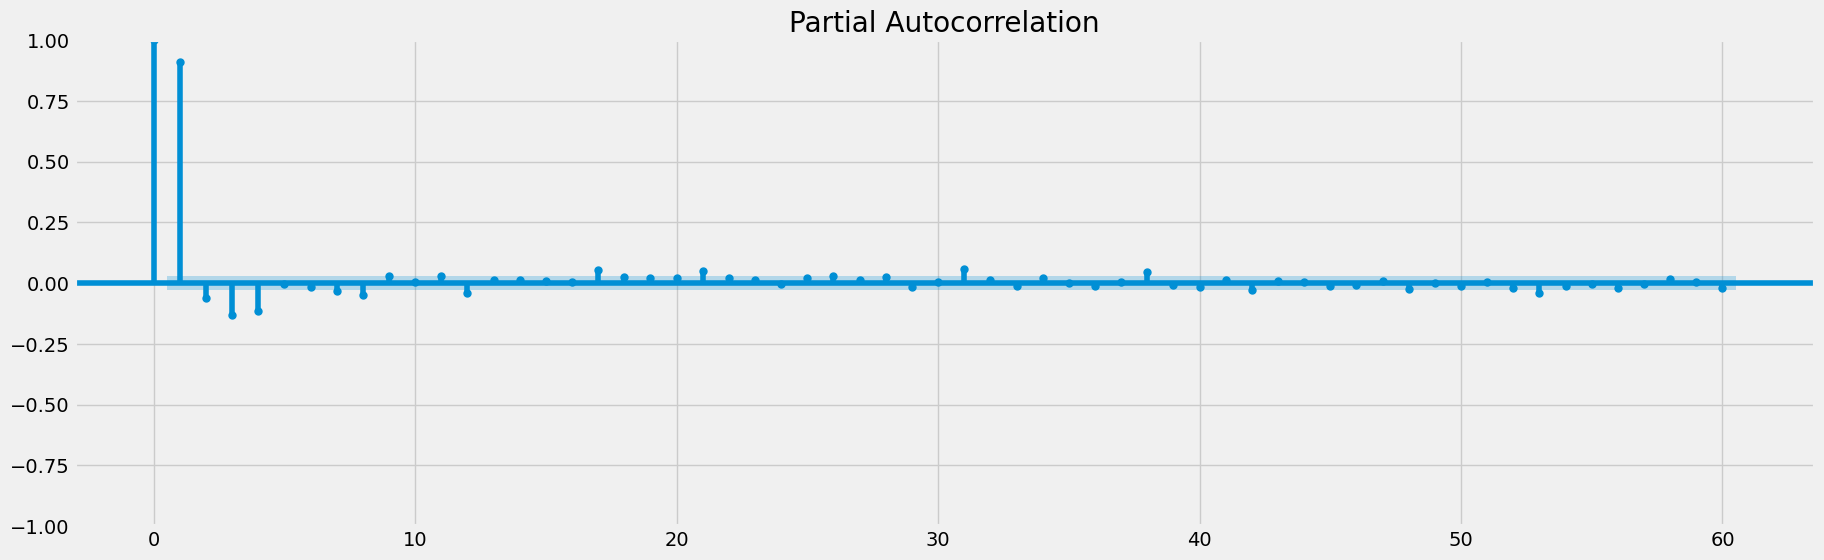

In [32]:
fig, ax = plt.subplots(figsize=(20, 6))

plot_pacf(data["co2"], lags=60, ax=ax)

plt.show()

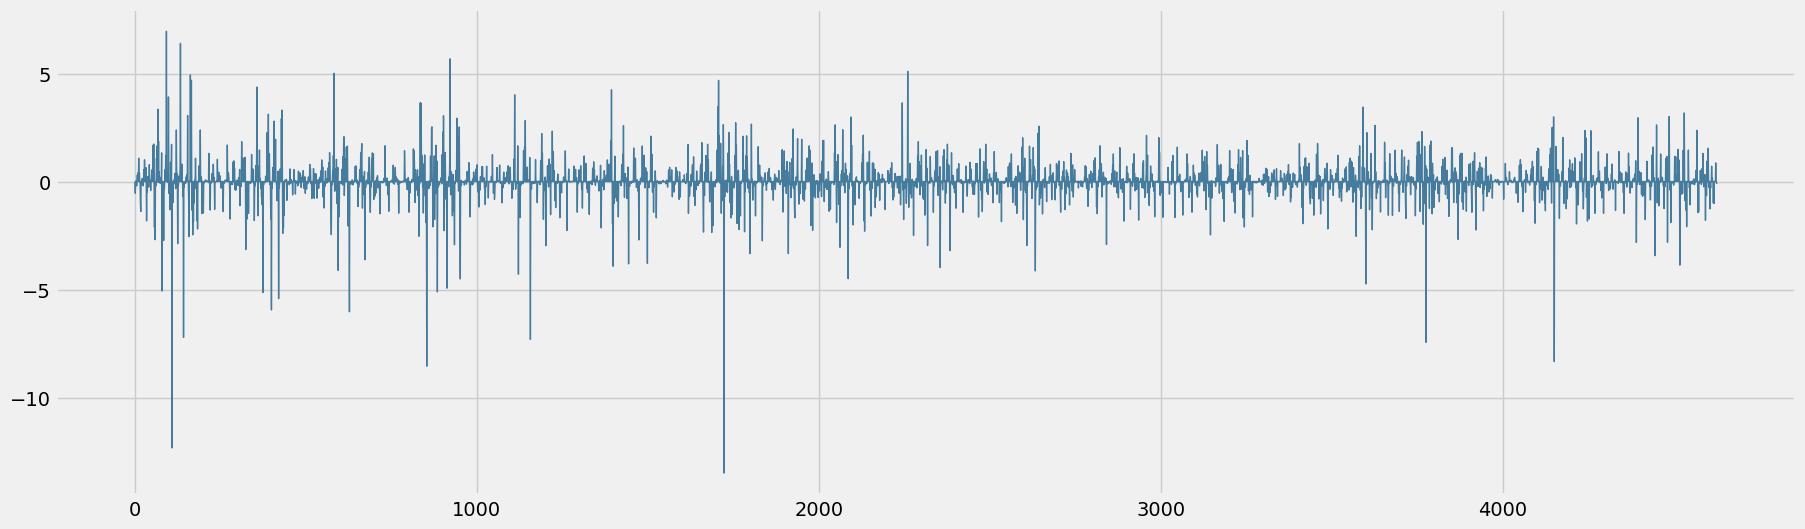

In [33]:
data_diff = data["co2"].diff().dropna()

plt.figure(figsize=(20, 6))

plt.plot(data_diff, linewidth=1, color="#457B9D")

plt.show()

In [34]:
resultado = adfuller(data_diff)

if resultado[1] > 0.05:
    print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
    print('Essa série provavelmente não é estacionária.')
else:
    print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
    print('Essa série provavelmente é estacionária.')


O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [35]:
resultado = kpss(data_diff)

if resultado[1] > 0.05:
    print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula (H0).')
    print('A série temporal provavelmente é estacionária.')
else:
    print('\nO valor-p é menor ou igual a 0.05 e, portanto, rejeitamos a hipótese nula (H0).')
    print('A série temporal provavelmente não é estacionária.')


O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula (H0).
A série temporal provavelmente é estacionária.


In [36]:
test_size = int(len(data_diff) * 0.2)
train_data = data_diff[:-test_size]
test_data = data_diff[-test_size:]

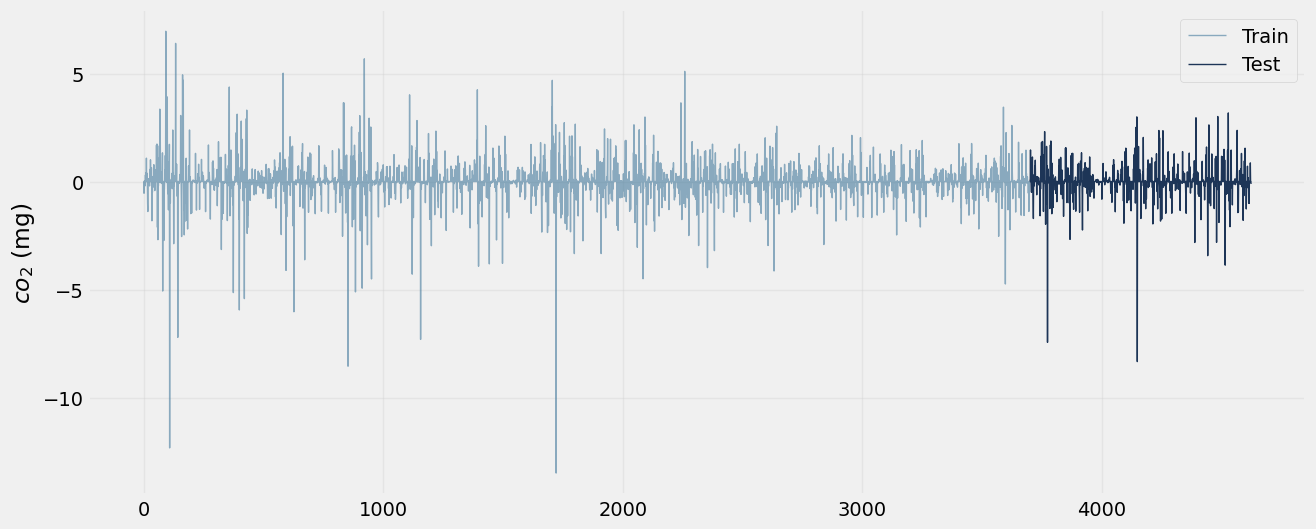

In [37]:
train_range = np.arange(len(train_data))
test_range = np.arange(len(train_data), len(train_data) + len(test_data))

plt.figure(figsize=(14, 6))

plt.plot(train_range, train_data, label='Train', color='#457B9D', alpha=0.6, linewidth=1)

plt.plot(test_range, test_data, label='Test', color='#1D3557', linewidth=1)

plt.ylabel("$co_2$ (mg)")

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

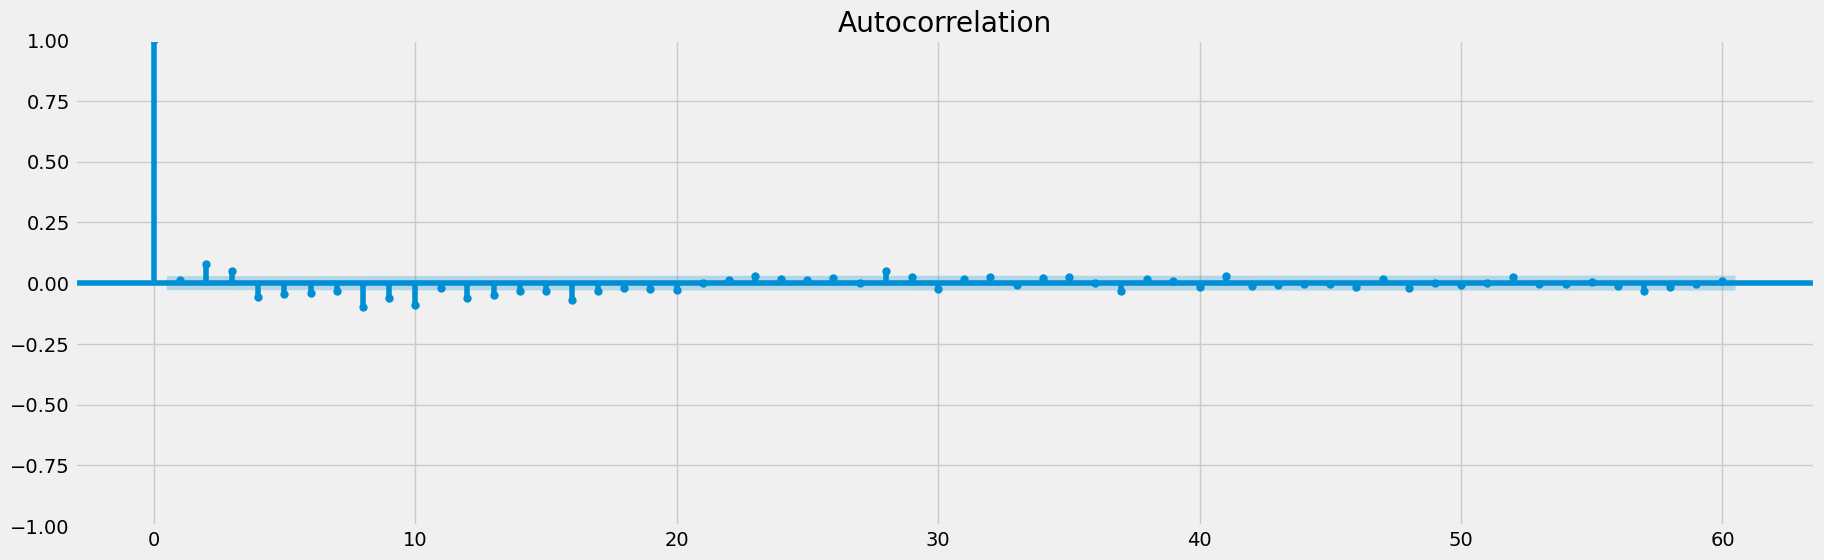

In [38]:
fig, ax = plt.subplots(figsize=(20, 6))

plot_acf(data_diff, lags=60, ax=ax)

plt.show()

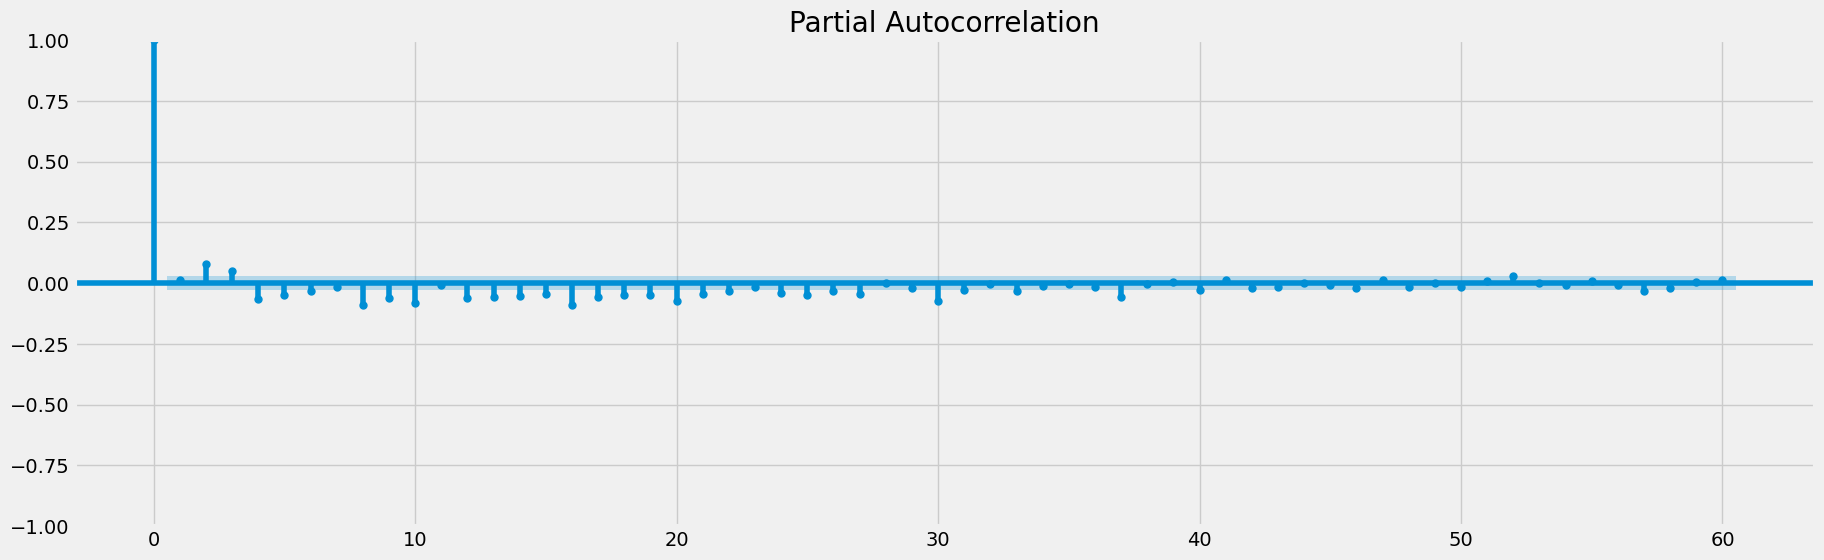

In [39]:
fig, ax = plt.subplots(figsize=(20, 6))

plot_pacf(data_diff, lags=60, ax=ax)

plt.show()

In [40]:
TRAIN_LEN = len(train_data)
HORIZON = len(test_data)
WINDOW = 1

history = [x for x in train_data]
pred_real = []

start_time_arima = time.time()

for i in range(HORIZON):
    model = SARIMAX(history[-5:], order=(1, 0, 1), enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)

    yhat_diff = res.forecast(steps=WINDOW)[0]

    valor_real_anterior = data["co2"].iloc[TRAIN_LEN + i - 1]
    
    yhat_real = valor_real_anterior + yhat_diff
    pred_real.append(yhat_real)

    obs_diff = test_data.iloc[i]

    history.append(obs_diff)

end_time_arima = time.time()

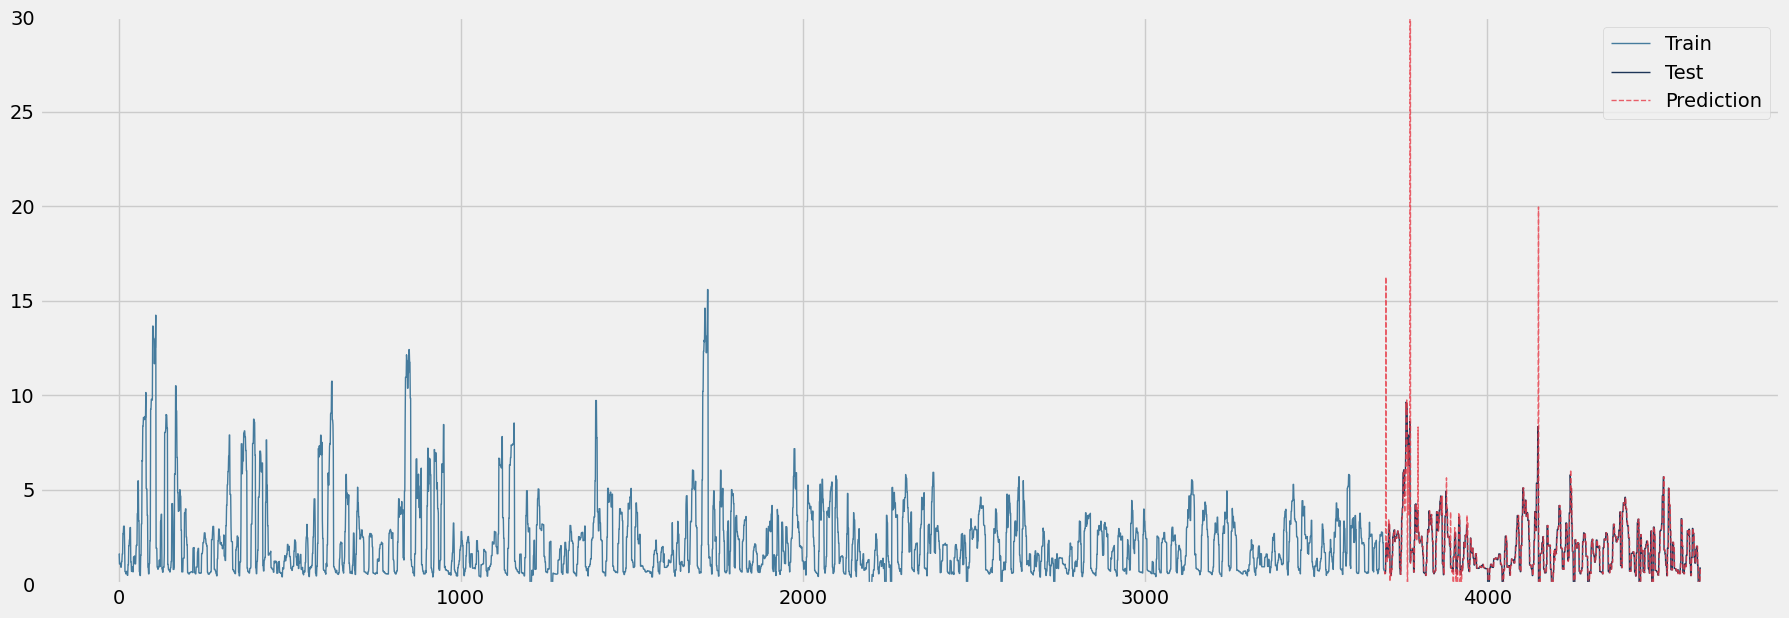

In [41]:
plt.figure(figsize=(20, 7))

x_axis_train = range(TRAIN_LEN)
x_axis_test = range(TRAIN_LEN, TRAIN_LEN + len(test_data))

train_real_plot = data["co2"].iloc[:TRAIN_LEN]
test_real_plot = data["co2"].iloc[TRAIN_LEN:TRAIN_LEN + len(test_data)]

plt.plot(x_axis_train, train_real_plot, label='Train', color='#457B9D', linewidth=1)
plt.plot(x_axis_test, test_real_plot, label='Test', color='#1D3557', linewidth=1)
plt.plot(x_axis_test, pred_real, label='Prediction', color='#E63946', alpha=0.8, linestyle='--', linewidth=1)

plt.ylim(0, 30)

plt.legend()
plt.show()

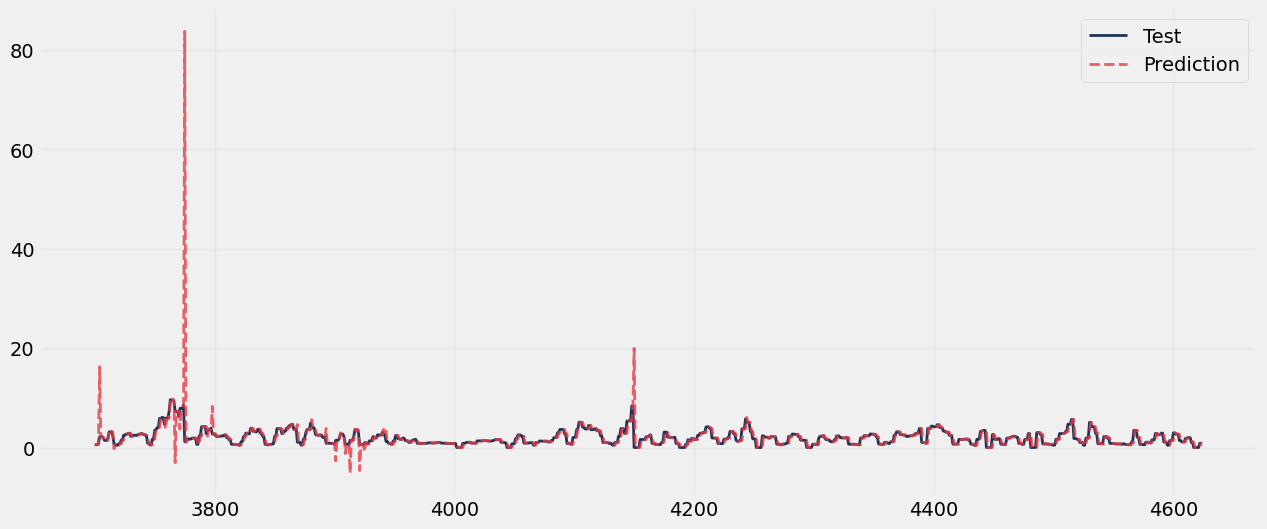

In [42]:
plt.figure(figsize=(14, 6))

plt.plot(x_axis_test, test_real_plot, label='Test', color='#1D3557', linewidth=2)

plt.plot(x_axis_test, pred_real, label='Prediction', color='#E63946', linestyle='--', alpha=0.8, linewidth=2)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

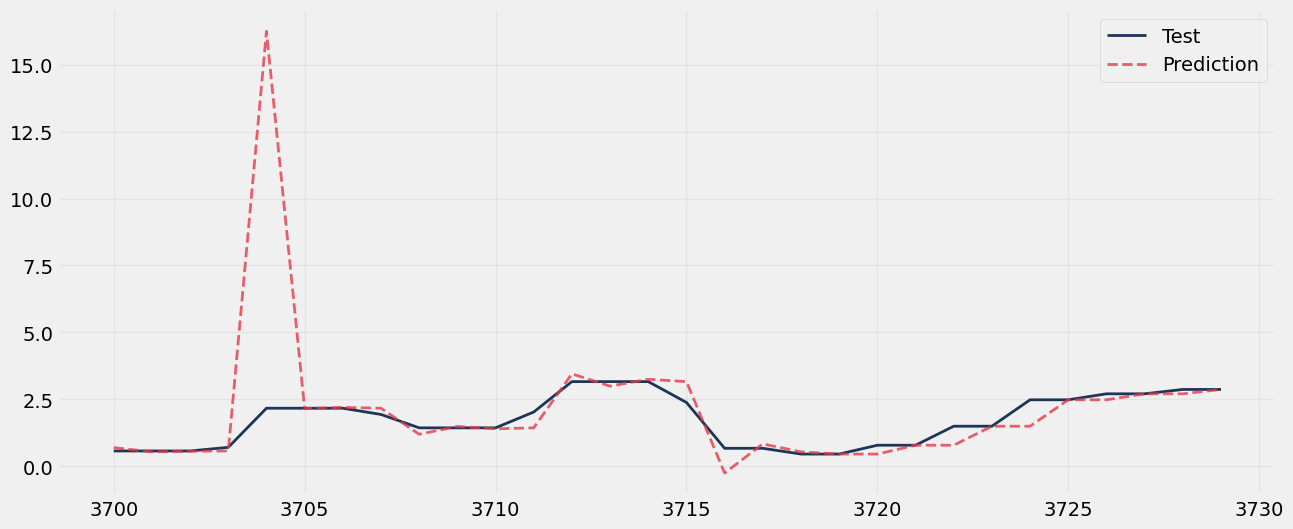

In [43]:
plt.figure(figsize=(14, 6))

plt.plot(x_axis_test[:30], test_real_plot[:30], label='Test', color='#1D3557', linewidth=2)

plt.plot(x_axis_test[:30], pred_real[:30], label='Prediction', color='#E63946', linestyle='--', alpha=0.8, linewidth=2)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [44]:
pd.DataFrame(evaluate(test_real_plot, pred_real), index=[0])

,mae,rmse,r2
0,0.452301,2.946855,-3.00484


In [45]:
total_time_arima = end_time_arima - start_time_arima
avg_time_per_step_arima = total_time_arima / HORIZON

avg_time_per_step_arima

0.012598904016855601

In [46]:
TRAIN_LEN = len(train_data)
HORIZON = len(test_data)
WINDOW = 1

history = [x for x in train_data]
pred_real = []

start_time_arima = time.time()

for i in range(HORIZON):
    model = SARIMAX(history, order=(1, 0, 1), enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)

    yhat_diff = res.forecast(steps=WINDOW)[0]

    valor_real_anterior = data["co2"].iloc[TRAIN_LEN + i - 1]
    
    yhat_real = valor_real_anterior + yhat_diff
    pred_real.append(yhat_real)

    obs_diff = test_data.iloc[i]

    history.append(obs_diff)

end_time_arima = time.time()

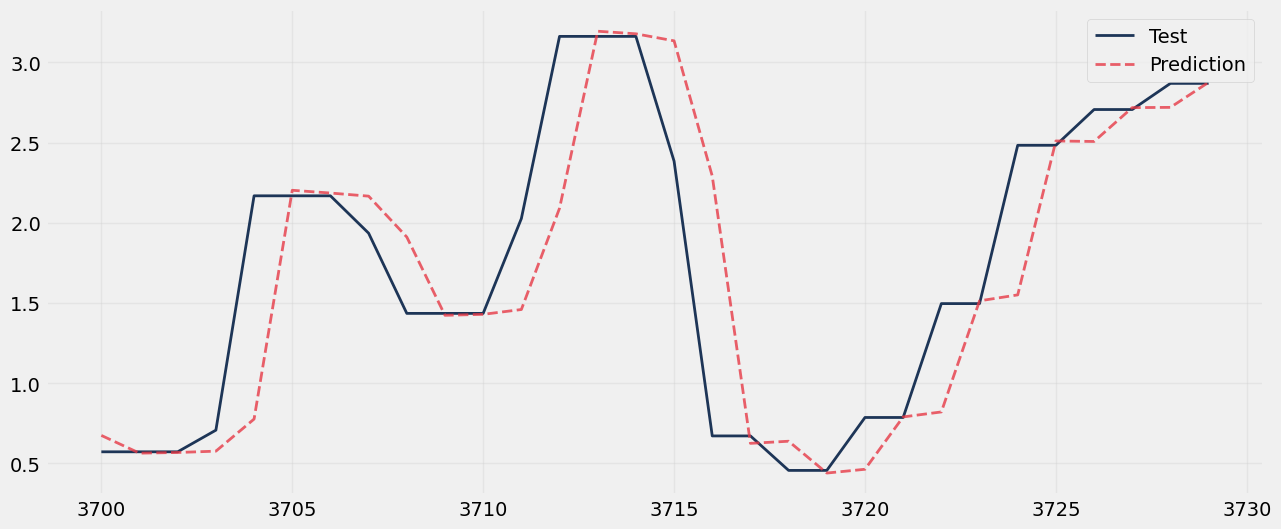

In [47]:
plt.figure(figsize=(14, 6))

plt.plot(x_axis_test[:30], test_real_plot[:30], label='Test', color='#1D3557', linewidth=2)

plt.plot(x_axis_test[:30], pred_real[:30], label='Prediction', color='#E63946', linestyle='--', alpha=0.8, linewidth=2)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [48]:
pd.DataFrame(evaluate(test_real_plot, pred_real), index=[0])

,mae,rmse,r2
0,0.309921,0.707807,0.768955


In [49]:
total_time_arima = end_time_arima - start_time_arima
avg_time_per_step_arima = total_time_arima / HORIZON

avg_time_per_step_arima

0.22929878157538336

In [50]:
TRAIN_LEN = len(train_data)
HORIZON = len(test_data)

history = [x for x in train_data]
pred_real = []

start_time_arima = time.time()

model = SARIMAX(history, order=(1, 0, 1), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

yhat_diff = res.forecast(steps=HORIZON)

end_time_arima = time.time()

last_real_value_train = data["co2"].iloc[TRAIN_LEN - 1]
pred_real = last_real_value_train + yhat_diff.cumsum()

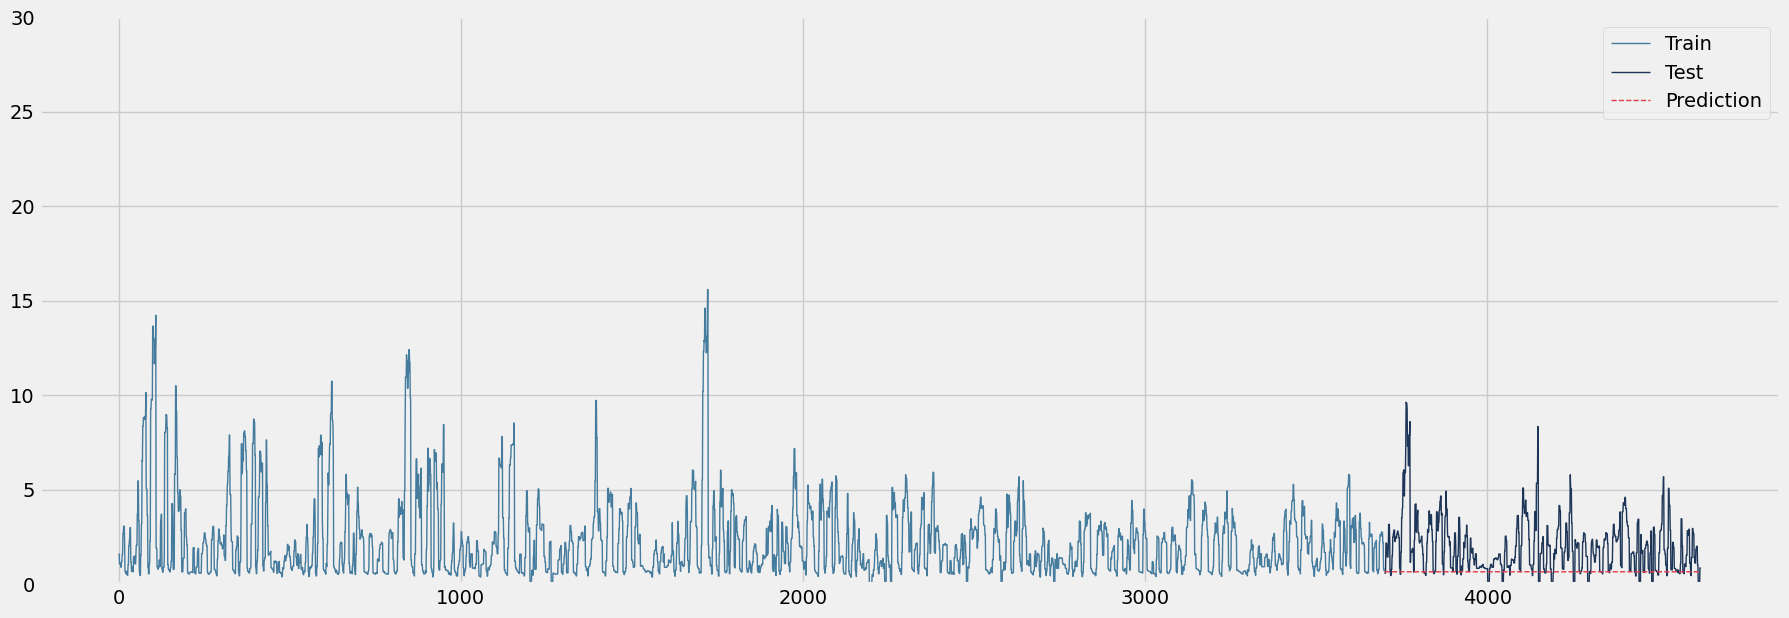

In [51]:
plt.figure(figsize=(20, 7))

x_axis_train = range(TRAIN_LEN)
x_axis_test = range(TRAIN_LEN, TRAIN_LEN + len(test_data))

train_real_plot = data["co2"].iloc[:TRAIN_LEN]
test_real_plot = data["co2"].iloc[TRAIN_LEN:TRAIN_LEN + len(test_data)]

plt.plot(x_axis_train, train_real_plot, label='Train', color='#457B9D', linewidth=1)
plt.plot(x_axis_test, test_real_plot, label='Test', color='#1D3557', linewidth=1)
plt.plot(x_axis_test, pred_real, label='Prediction', color='#E63946', linestyle='--', linewidth=1)

plt.ylim(0, 30)

plt.legend()
plt.show()

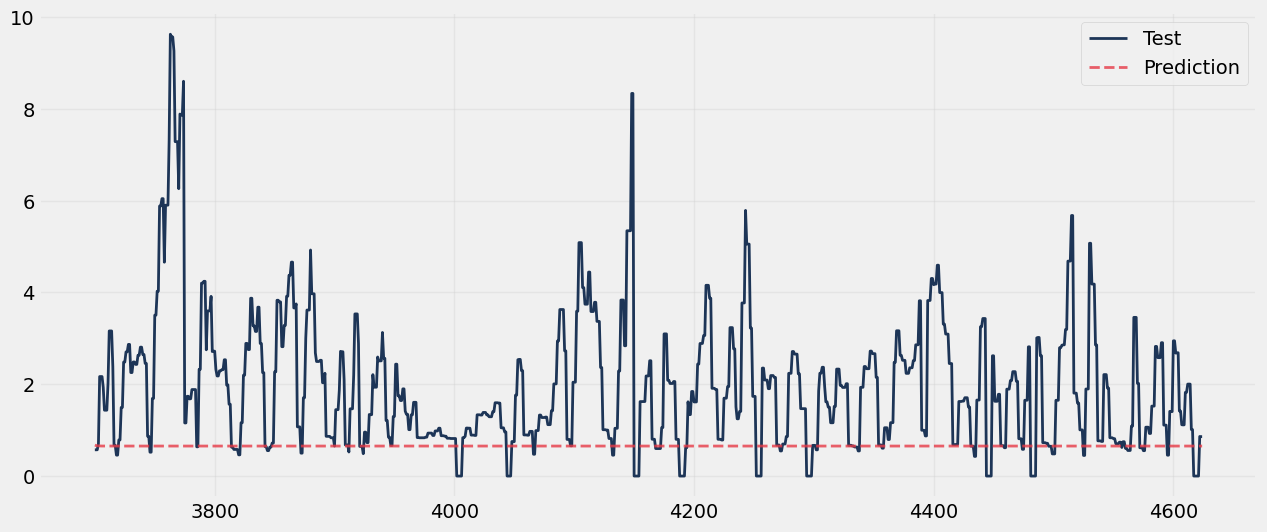

In [52]:

plt.figure(figsize=(14, 6))

plt.plot(x_axis_test, test_real_plot, label='Test', color='#1D3557', linewidth=2)

plt.plot(x_axis_test, pred_real, label='Prediction', color='#E63946', linestyle='--', alpha=0.8, linewidth=2)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

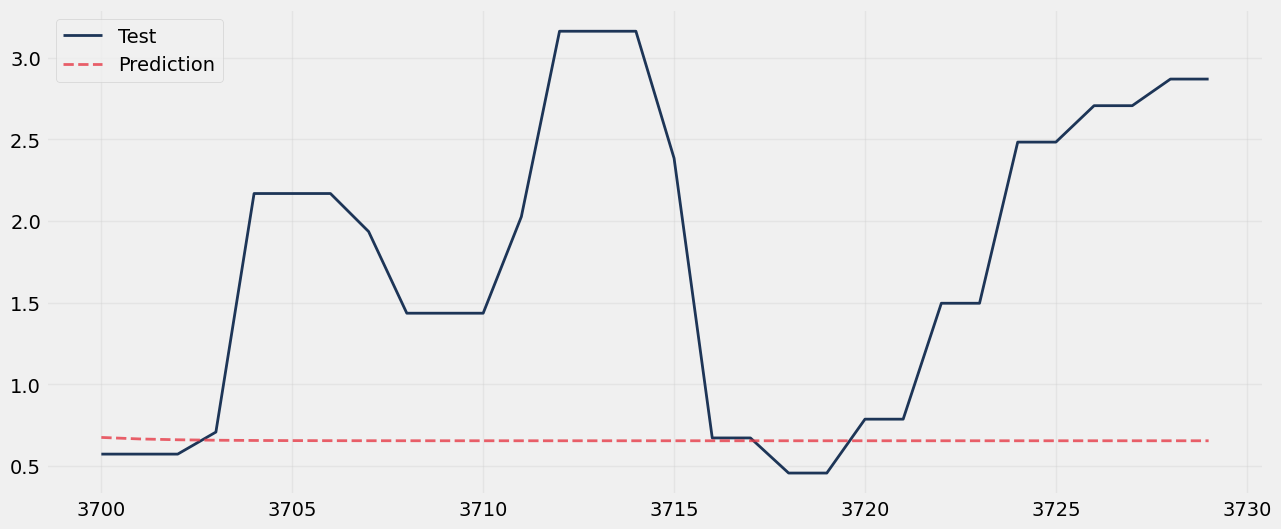

In [53]:
plt.figure(figsize=(14, 6))

plt.plot(x_axis_test[:30], test_real_plot[:30], label='Test', color='#1D3557', linewidth=2)

plt.plot(x_axis_test[:30], pred_real[:30], label='Prediction', color='#E63946', linestyle='--', alpha=0.8, linewidth=2)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [54]:
pd.DataFrame(evaluate(test_real_plot, pred_real), index=[0])

,mae,rmse,r2
0,1.394714,1.975554,-0.799889


In [55]:
total_time_arima = end_time_arima - start_time_arima
avg_time_per_step_arima = total_time_arima / HORIZON

avg_time_per_step_arima

0.00021516129777238177

In [56]:
TRAIN_LEN = len(train_data)
HORIZON = len(test_data)
WINDOW = 1

history = [x for x in train_data]
pred_real = []

start_time_arima = time.time()

for i in range(HORIZON):
    model = SARIMAX(history, order=(1, 0, 1), enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)

    yhat_diff = res.forecast(steps=WINDOW)[0]

    valor_real_anterior = data["co2"].iloc[TRAIN_LEN + i - 1]
    
    yhat_real = valor_real_anterior + yhat_diff
    pred_real.append(yhat_real)

    obs_diff = test_data.iloc[i]

    history.append(obs_diff)

end_time_arima = time.time()

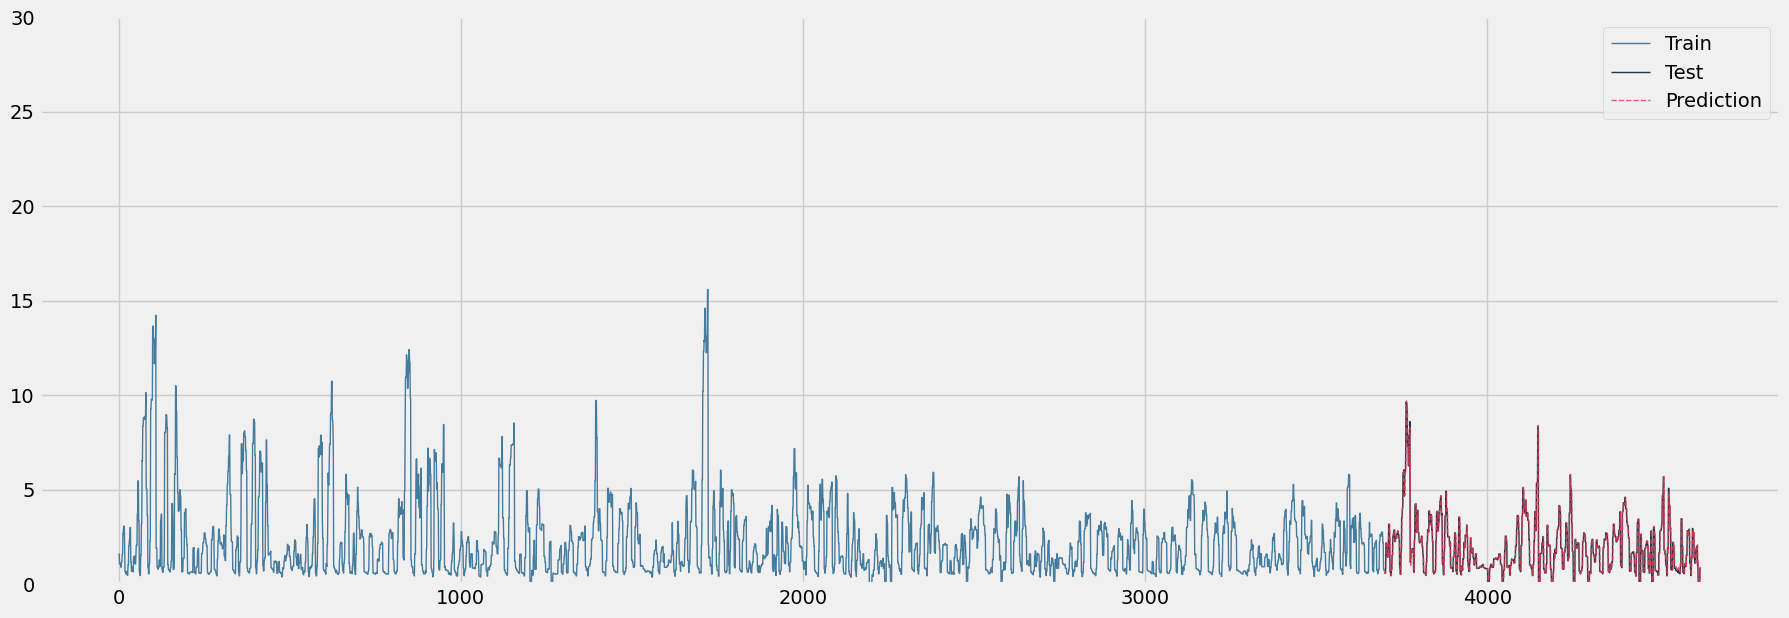

In [57]:
plt.figure(figsize=(20, 7))

x_axis_train = range(TRAIN_LEN)
x_axis_test = range(TRAIN_LEN, TRAIN_LEN + len(test_data))

train_real_plot = data["co2"].iloc[:TRAIN_LEN]
test_real_plot = data["co2"].iloc[TRAIN_LEN:TRAIN_LEN + len(test_data)]

plt.plot(x_axis_train, train_real_plot, label='Train', color='#457B9D', linewidth=1)
plt.plot(x_axis_test, test_real_plot, label='Test', color='#1D3557', linewidth=1)
plt.plot(x_axis_test, pred_real, label='Prediction', color='#E63946', alpha=0.8, linestyle='--', linewidth=1)

plt.ylim(0, 30)

plt.legend()
plt.show()

In [58]:
pd.DataFrame(evaluate(test_real_plot, pred_real), index=[0])

,mae,rmse,r2
0,0.309921,0.707807,0.768955


In [59]:
total_time_arima = end_time_arima - start_time_arima
avg_time_per_step_arima = total_time_arima / HORIZON

avg_time_per_step_arima

0.23030238074225348